### Importing Everything Require

In [12]:
import warnings
import os
from helper import get_detail, plot33, tr_plot

warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf

2021-11-29 15:19:47.726818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Getting and knowing dataset

In [3]:
project_root = os.path.abspath("..")
TRAIN_DIR = project_root + '/backend/train'
VALID_DIR = project_root + '/backend/test'
IMAGE_SIZE = (25,25)

#### Exploring Dataset

In [4]:
train_images = get_detail(TRAIN_DIR,'training')

We have 1700 training images for 0
We have 1700 training images for 1
We have 1700 training images for 2
We have 1700 training images for 3
We have 1700 training images for 4
We have 1700 training images for 5
We have 1700 training images for 6
We have 1700 training images for 7
We have 1700 training images for 8
We have 1700 training images for 9


In [5]:
val_images = get_detail(VALID_DIR,'validation')

We have 300 validation images for 0
We have 300 validation images for 1
We have 300 validation images for 2
We have 300 validation images for 3
We have 300 validation images for 4
We have 300 validation images for 5
We have 300 validation images for 6
We have 300 validation images for 7
We have 300 validation images for 8
We have 300 validation images for 9


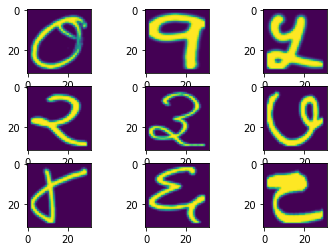

In [6]:
plot33(TRAIN_DIR,train_images)

#### Getting Dataset

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255, rotation_range=90,
    horizontal_flip=True, vertical_flip=True,
    fill_mode='nearest', validation_split=0.1,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, batch_size=16, color_mode='grayscale',
    target_size=IMAGE_SIZE, subset='training',
)

test_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, batch_size=16,color_mode='grayscale',
    target_size=IMAGE_SIZE, subset='validation',
)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(VALID_DIR,batch_size=16)

Found 15300 images belonging to 10 classes.
Found 1700 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


### Creating Model

In [8]:
NUM_EPOCH = 20
LR = 0.0001
INPUT_SHAPE = (25,25,1)
ACT_FUNCTION = 'relu'
RESULT_ACT_FUNCTION = 'softmax'

In [9]:
def poly_decay( epoch):
    maxEpochs = NUM_EPOCH
    baseLR = LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha
    
inp = tf.keras.Input(shape=INPUT_SHAPE)

x = layers.Conv2D(128, (5, 5), activation=ACT_FUNCTION, padding='same')(inp)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation=ACT_FUNCTION)(x)

encoder = tf.keras.Model(inputs=inp, outputs=x)

inp = tf.keras.Input(shape=(25, 25, 1))
x = encoder(inp)
out = layers.Dense(10, activation=RESULT_ACT_FUNCTION)(x)

model = tf.keras.Model(inputs=inp, outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
             loss='categorical_crossentropy',
             metrics=['acc']
             )

model.summary()

2021-11-29 15:19:51.542675: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-29 15:19:51.544881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-29 15:19:51.596932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 15:19:51.597796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce 930MX computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 13.41GiB/s
2021-11-29 15:19:51.597852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-29 15:19:51.639332: I tensorflow/stream_executor/platform/defaul

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 128)               891904    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 893,194
Trainable params: 891,658
Non-trainable params: 1,536
_________________________________________________________________


In [10]:
checkpoint = [
    ModelCheckpoint('best-model.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto'),
    LearningRateScheduler(poly_decay,verbose=1)
]

### Trainning and Saving 

In [11]:
history = model.fit(
    train_generator,
    epochs=NUM_EPOCH,
    validation_data=test_generator,
    callbacks=checkpoint
)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.


2021-11-29 15:19:53.394771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-29 15:19:53.415564: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
2021-11-29 15:19:54.285254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-29 15:19:55.627179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-29 15:19:55.635516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


957/957 [==============================] - 63s 57ms/step - loss: 2.0980 - acc: 0.2969 - val_loss: 1.5259 - val_acc: 0.4671

Epoch 00001: val_loss improved from inf to 1.52590, saving model to best-model.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 9.5e-05.
957/957 [==============================] - 52s 55ms/step - loss: 1.2528 - acc: 0.5445 - val_loss: 0.9564 - val_acc: 0.6529

Epoch 00002: val_loss improved from 1.52590 to 0.95640, saving model to best-model.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 9e-05.
957/957 [==============================] - 52s 55ms/step - loss: 0.9297 - acc: 0.6681 - val_loss: 0.7013 - val_acc: 0.7559

Epoch 00003: val_loss improved from 0.95640 to 0.70131, saving model to best-model.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 8.5e-05.
957/957 [==============================] - 52s 55ms/step - loss: 0.6860 - acc: 0.7677 - val_loss: 0.4915 - val_acc: 0.8294

Epoch 

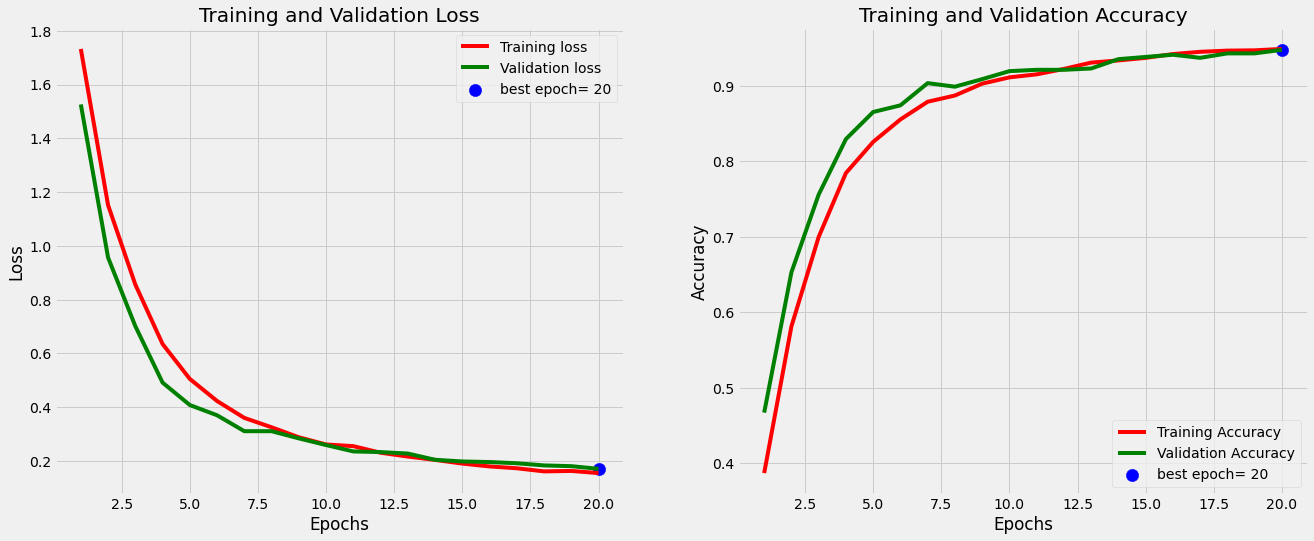

In [22]:
tr_plot(history,0)

## Evaluation

### Reference

1. [How to Load Large Datasets From Directories for Deep Learning in Keras](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/)
2. [CNN classifier for MNIST](https://www.kaggle.com/vesran/cnn-classifier-for-mnist-0-99-acc-in-test)
3. 